In [1]:
import h5py
import pylab as pl
import numpy as np
#import matplotlib as mpl
import networkx

In [2]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)

In [3]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [4]:
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [5]:
# maybe I don't need the sim for this, but there it is, anyway
# sooo, pick one
fofID = 82
uniqueID = int(127*1e6+fofID)

stree = networkx.dfs_tree(trees, str(uniqueID))

In [6]:
stree

In [7]:
uid = uniqueID

while True:
    successors = list(stree.successors(str(uid)))
    if len(successors) == 0:
        break
    print(uid, '\n', successors, '\n---------------------------<')
    uid = successors[0]

127000082 
 ['126000082'] 
---------------------------<
126000082 
 ['125000085', '125000106'] 
---------------------------<
125000085 
 ['124000088'] 
---------------------------<
124000088 
 ['123000083'] 
---------------------------<
123000083 
 ['122000078', '122000091'] 
---------------------------<
122000078 
 ['121000075'] 
---------------------------<
121000075 
 ['120000072'] 
---------------------------<
120000072 
 ['119000072'] 
---------------------------<
119000072 
 ['118000073'] 
---------------------------<
118000073 
 ['117000069'] 
---------------------------<
117000069 
 ['116000063'] 
---------------------------<
116000063 
 ['115000063'] 
---------------------------<
115000063 
 ['114000060'] 
---------------------------<
114000060 
 ['113000060'] 
---------------------------<
113000060 
 ['112000067'] 
---------------------------<
112000067 
 ['111000058'] 
---------------------------<
111000058 
 ['110000064'] 
---------------------------<
110000064 
 ['10900012

In [8]:
# I think I got it. Maybe I did the thing just here

def get_main_branch_and_progNumb(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    numb = [[node], ]
    i = 0
    while True:
        successors = list(subtree.successors(node))
        if len(successors) == 0:
            break
        node = successors[0] # select only the first succesor (main branch)
        mpb.append(node)
        numb.append(successors)
        
    return mpb, numb

In [58]:
def plotZ(fofID, centralID):
    uniqueID = int(127*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree, numbs = get_main_branch_and_progNumb(stree, str(uniqueID))
    
    uniqueC = int(127*1e6+centralID)
    streeC = networkx.dfs_tree(trees, str(uniqueC))
    mtreeC, numbsC = get_main_branch_and_progNumb(streeC, str(uniqueC))
    
    # find all the particleIDs that once belong to the subgroup
    Idlist, zlist, zcen = [], [], []

    galH, cenH, snapcen = [], [], []
    
    for mm, mmC in zip(mtree[1:], mtreeC[1:]): # ignore the first one
        snap, idd = split_unique_id(int(mm))
        snapC, iddC = split_unique_id(int(mmC))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        pgal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        zt = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
        if snapC==snap:
            pcen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapC)][iddC]
#         galH.append(pgal)
#         cenH.append(pcen)
#         zcen.append(zt)
        snapcen.append(int(snap))
        zcen.append(zt)
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            Idlist.extend(list(tempIds))
#             zlist.extend([zt]*tempIds.size)
            zlist.extend([int(snap)]*tempIds.size)

    Idlist, zlist = np.array(Idlist), np.array(zlist)
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    zlist = zlist[Idunique]

    galH = np.array(galH)
    cenH = np.array(cenH)
    zcen = np.array(zcen)
    snapcen = np.array(snapcen)
    
    # the total list of particles that once belong to a give subgroup, lest see where are today.
    TdayOff = sim['SnapNumber_127/SubGroups/PartType0/Offsets'][fofID].astype('int')
    TdayCoord = sim['SnapNumber_127/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]

    TdayTotalIDs = sim['SnapNumber_127/PartType0/ParticleIDs'][()]
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    #remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_127/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
#     LostCoord = sim['SnapNumber_127/PartType0/Coordinates'][IndexT_]

    # ... and the redshift
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    zlist_, Idlist_ = zlist[iidex_], Idlist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    zorder = np.zeros(IndexT_.size)
    zorder[is1] = zlist_[is2]
    
    #now lets cut at  a certain distance, nope, not now.
#     distance = 600 # distance in ckpc

#     posGal = sim['SnapNumber_127/SubGroups/SubGroupPos'][fofID]
#     posCen = sim['SnapNumber_127/SubGroups/SubGroupPos'][centralID]

#     dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
#     distToC = np.sqrt(dx**2+dy**2+dz**2)

#     icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_
    zorder_near = zorder
    
    #NearCoord = LostCoord
    
#     # ok, lest see velocity and stuff
#     velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][centralID]
#     velSat = sim['SnapNumber_128/SubGroups/SubGroupVel'][fofID]

#     cenRep = posGal - posCen

#     velRep = velSat - velCen
    
#     xo, yo, zo = NearCoord[:,0], NearCoord[:,1], NearCoord[:,2]
#     xoC, yoC, zoC = xo - posCen[0], yo - posCen[1], zo - posCen[2]
#     velX, velY, velZ = velRep[0], velRep[1], velRep[2]

#     #cenPx, cenPy, cenPz = galH[:,0] - posCen[0], galH[:,1] - posCen[1], galH[:,2] - posCen[2]
#     cenPx, cenPy, cenPz = galH[:,0] - cenH[:,0], galH[:,1] - cenH[:,1], galH[:,2] - cenH[:,2]

#     nzbins = 4
#     # zlim = np.linspace(zorder_near.min(), zorder_near.max(), nzbins+1)
#     zli = np.percentile(zorder, [25, 50, 75, 100])
#     zlim = [0.]
#     zlim.extend(list(zli))
#     zlim = np.array(zlim)

#     for i in range(zlim.size):
#         zlim[i] = float(int(zlim[i]*10))/10
    
#     colourlist = ['blue', 'green', 'orange', 'red']
    
#     fig = ipv.figure(width=750, height=750)
    
#     for zi, zm, colour in zip(zlim[:-1], zlim[1:], colourlist):
#         print(colour,'\t:','{} < z < {}'.format(zi, zm))
#         i = np.where((zorder_near>zi) & (zorder_near<zm))
#         xoCT ,yoCT, zoCT = xoC[i], yoC[i], zoC[i]
#         scatter = ipv.scatter(xoCT, yoCT, zoCT, marker='sphere', size=.25, color=colour)
        
#         iz = np.where((zcen>zi) &(zcen<zm))
#         ipv.plot(cenPx[iz], cenPy[iz], cenPz[iz], ls='--', color=colour)
    
# #     ipv.plot(cenPx, cenPy, cenPz, ls='--', color='black')
#     ipv.quiver(np.array([cenRep[0]]), np.array([cenRep[1]]), np.array([cenRep[2]]), np.array([velX]), np.array([velY]), np.array([velZ]), color='black', size=10)
#     #ipv.xlabel('x/(ckpc h^{-1})')
#     #ipv.ylabel('y/(ckpc h^{-1})')
#     #ipv.zlabel('z/(ckpc h^{-1})')
    
#     ipv.show()
    
    zmin, zmax = zorder_near.min(), zorder_near.max()
    nz = np.unique(zorder_near)
    
    nzs = nz.size
    delta = (zmax-zmin)/(nzs-1.)
    delta1 = nz[1]-nz[0]
    delta2 = nz[-1]-nz[-2]
    range1 = [zmin-0.5*delta1]
    range3 = [zmax+0.5*delta2]
    range2 = list((nz[:-1]+nz[1:])*.5)
    
    range1.extend(range2)
    range1.extend(range3)
    range1 = np.array(range1)
    
    pl.figure(figsize=(18, 10))
    
    fig, ax1 = pl.subplots(figsize=(18, 10))

    ax2 = ax1.twinx()
    ax3 = ax1.twiny()
    
#     ax1.plot(x, y1, 'g-')
#     ax2.plot(x, y2, 'b-')

#     ax1.set_xlabel('X data')
#     ax1.set_ylabel('Y1 data', color='g')
#     ax2.set_ylabel('Y2 data', color='b')

    
    
#     pl.hist(zorder_near, range=(zmin-0.5*delta, zmax+0.5*delta), bins=nzs)
    ax1.hist(zorder_near, bins=range1, histtype='stepfilled')
    ax3.hist(zorder_near, bins=range1, histtype='step')
    
    ymim, ymax = pl.ylim()
    
    maxx = 0
    for i, z in enumerate(snapcen):
        if len(numbs[i]) > 1:
            main = numbs[i][0]
            snap, fofi = split_unique_id(int(main))
            offM = sim['SnapNumber_{}/SubGroups/PartType1/Offsets'.format(snap)][fofi]
            mainN = offM[1]-offM[0]
            otherN = 0
            for n in numbs[i][1:]:
                snapS, fofS = split_unique_id(int(n))
                offS = sim['SnapNumber_{}/SubGroups/PartType1/Offsets'.format(snapS)][fofS]
                otherN += offS[1] - offS[0]
            ratio = otherN/mainN
#             pl.arrow(z, 0, 0, ymax*ratio, color='black')
            if ratio>maxx:
                maxx = ratio
            ax2.arrow(z, 0, 0, ratio, color='black')
            
#     pl.xlabel('redshfit')
#     pl.ylabel('Number of gas particles stripped from the galaxy')
    
#     ax1.set_xlabel('redshfit')
    ax1.set_xlabel('Snapshot Number')
    ax1.set_ylabel('Number of gas particles stripped from the galaxy')
    
    ax2.set_ylabel('DM Mass ratio')
    ax2.set_ylim([0, maxx+0.025])
    

    xtt = ax3.get_xticks()
    
    zticks = np.zeros(xtt.size-2)
    for j, xt in enumerate(xtt[1:-1]):
        i = np.where(snapcen==xt)[0][0]
        zticks[j] = np.float(np.int(zcen[i]*1e2))/1e2
    
    ax3.set_xlabel('z')
    pl.xticks(ticks=xtt[1:-1] ,labels=zticks)

<Figure size 1296x720 with 0 Axes>

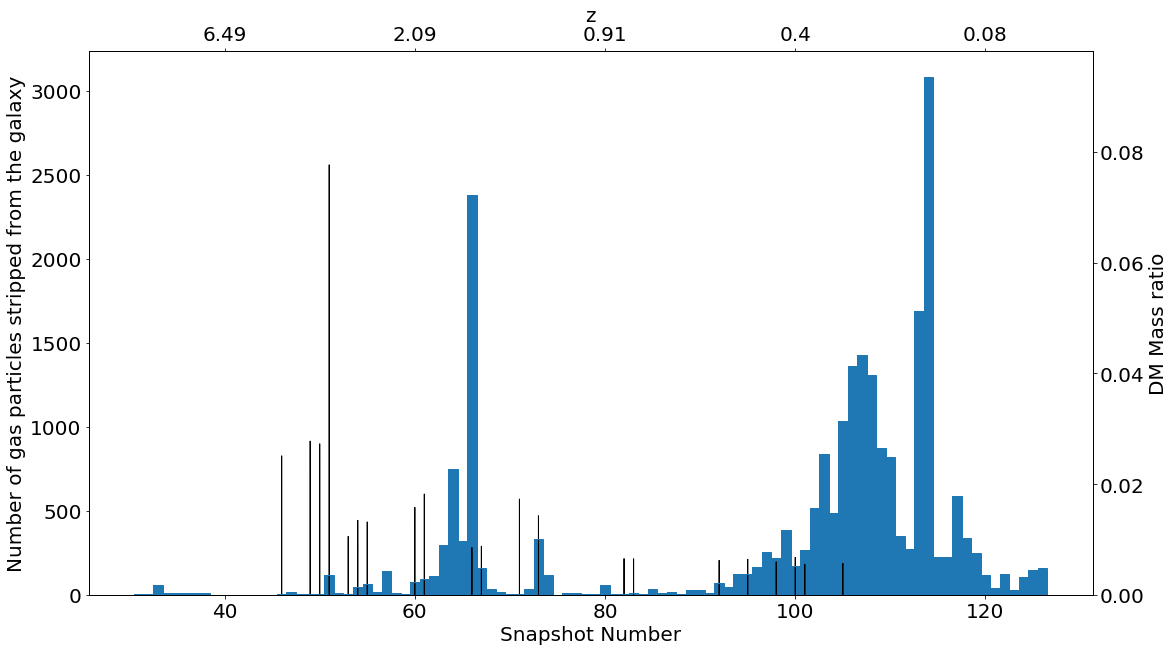

In [59]:
#  4338, 4341 (4337), 4470 y 4474 (4469)
plotZ(4338,4337)

<Figure size 1296x720 with 0 Axes>

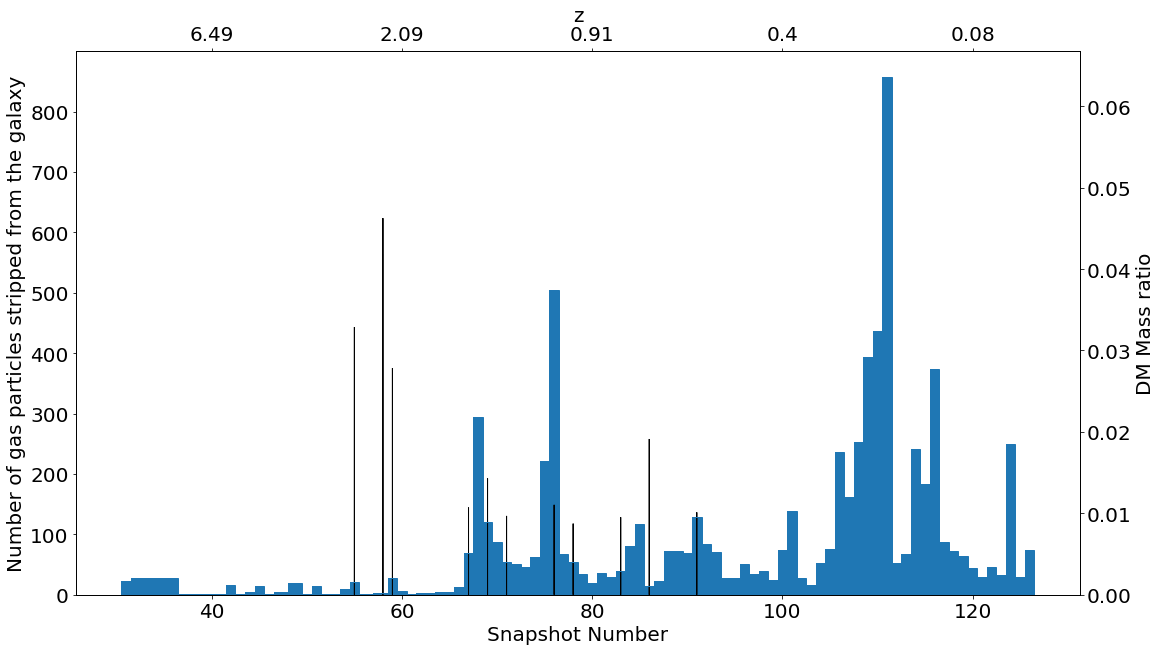

In [60]:
plotZ(4341,4337)

<Figure size 1296x720 with 0 Axes>

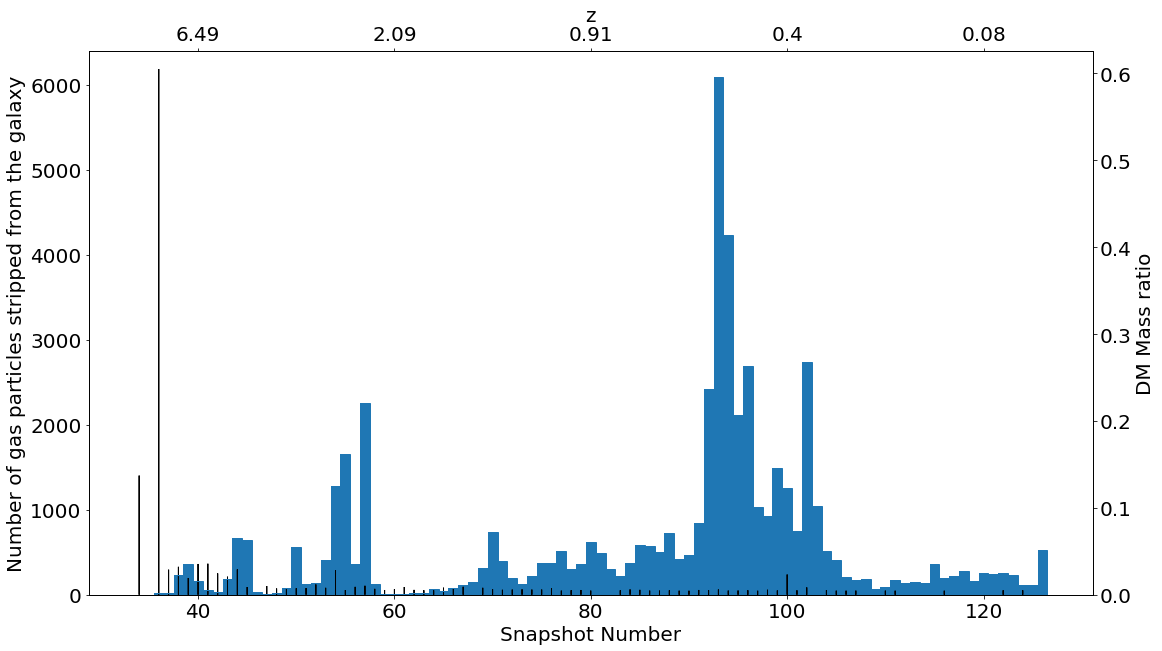

In [61]:
plotZ(4470,4469)

<Figure size 1296x720 with 0 Axes>

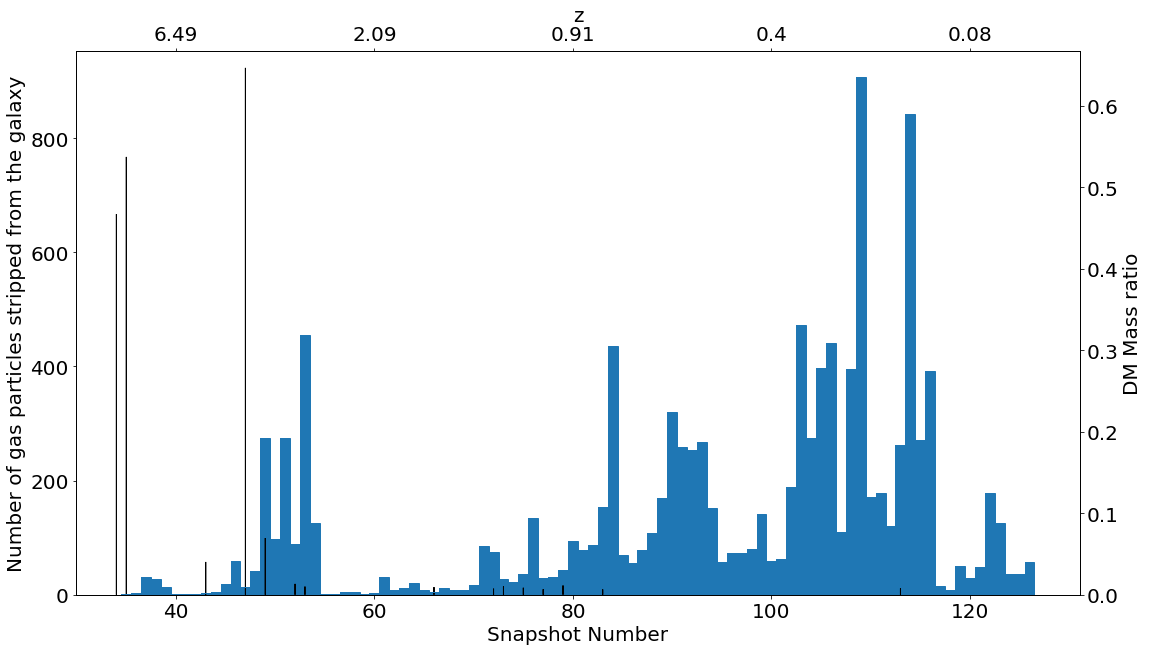

In [62]:
plotZ(4474,4469)

Object `ax3.set_xticks` not found.
